# Introduction

## Final Project Submission

***
- Student Name: Adam Marianacci
- Student Pace: Flex
- Scheduled project review date/time: TBD
- Instructor Name: Mark Barbour

# Business Understanding

It is my job to help SXSW detect positive sentiment from tweets about their event so that they can continue to give people what they want and make improvements for future conferences.

# Data Understanding

This dataset comes from 'CrowdFlower' via data.world. The initial dataframe contained roughly 9,000 tweets and information about the sentiment of the tweet as well as what brand or product the tweet was directed at. Some limitations of the dataset included missing values as well as a class imbalance in the sentiment of the tweets. Over 50% of the tweets showed no emotion, about 33% showed a positive emotion, and only around 6% showed a negative emotion. Due to this imbalance I combined some of the 'no emotion' tweets with the 'negative emotion' tweets to create a 'Not Positive' class to match the 'Positive' class. There was a lot of missing data from the emotion about the brands so I was unable to conduct analysis in this area. The dataset was also fairly small for predictive modeling. This dataset was suitable for the project because it allowed me to build a sentiment detection model from the text in the tweets against the target 'sentiment' of what tweets were considered positive and which were not.

Dataset: [Brands and Product Emotions](https://data.world/crowdflower/brands-and-product-emotions)

# Data Preperation

In [1]:
# Importing the necessary libraries

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import defaultdict
from collections import Counter
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the data, and looking at the shape of the df

corpus = pd.read_csv('data/twitter_sentiment.csv', encoding='latin1')
corpus.shape

(9093, 3)

In [3]:
# previewing the dataframe
corpus.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# Taking a look at the datatypes and checking for missing values
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
# Dropping 'the emotion_in_tweet_is_directed_at' column, bc of missing values and not needed for our problem.
corpus.drop('emotion_in_tweet_is_directed_at', axis=1, inplace=True)

In [6]:
# renaming the 'is_there_an_emotion...' column to 'sentiment'
corpus.rename(columns={
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

In [7]:
# Inspecting the values in 'sentiment'. We have an imbalance in occurences. 
corpus['sentiment'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [8]:
# Dropping 'I can't tell' category because it is not useful and a relatively low amount.
corpus.drop(corpus[corpus['sentiment'] == "I can't tell"].index, inplace=True)

In [9]:
# Creating a mask to identify rows with "No emotion toward brand or product"
no_emotion_mask = corpus['sentiment'] == "No emotion toward brand or product"

# Locating the rows with the mask and redistribute 2,408 occurrences
no_emotion_indices = corpus[no_emotion_mask].sample(n=2408, random_state=42).index
corpus.loc[no_emotion_indices, 'sentiment'] = "Negative emotion"

# Verifying the changes
print(corpus['sentiment'].value_counts())

No emotion toward brand or product    2981
Negative emotion                      2978
Positive emotion                      2978
Name: sentiment, dtype: int64


In [10]:
# Creating a mask to identify rows with "No emotion toward brand or product"
no_emotion_mask = corpus['sentiment'] == "No emotion toward brand or product"

# Drop the rows with this mask
corpus.drop(corpus[no_emotion_mask].index, inplace=True)

# Verify the changes
print(corpus['sentiment'].value_counts())

Negative emotion    2978
Positive emotion    2978
Name: sentiment, dtype: int64


In [11]:
# Define the mapping of old values to new values
mapping = {'Positive emotion': 'Positive', 'Negative emotion': 'Not Positive'}

# Replace the categories in the 'sentiment' column
corpus['sentiment'] = corpus['sentiment'].replace(mapping)

# Verify the changes
print(corpus['sentiment'].value_counts())

Positive        2978
Not Positive    2978
Name: sentiment, dtype: int64


In [12]:
# Assigning 'Positive' sentiment to 1 and 'Not Positive' to 0
corpus['sentiment'] = corpus['sentiment'].replace(
    {'Positive': 1, 'Not Positive': 0})

In cells 9-12 we have set this up to be a binary classification problem. We have combined values from "Negative emotion" with values from "No emotion toward brand or product". We did this because we had a class imbalance. We sampled 2,408 occurences from "No emotion toward brand or product" and combined them in the "Negative emotion" category to create a new category called "Not Positive". There were a lot more occurences of "Positive emotion" compared to "Negative emotion". By combining the categories we have now have a balance between 'Positive' and 'Not Positive' occurences. We have assigned sentiment values 'Positive' to 1 and 'Not Positive' to 0.

In [13]:
# Inspecting the DF once again to make sure everything looks correct after all the changes we made.
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5956 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5956 non-null   object
 1   sentiment   5956 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 139.6+ KB


In [14]:
# previewing the cleaned up df
corpus.head()

,tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1


Inspecting common words that could have low semantic value and could potentially be added to 'stopwords'

In [15]:
# Finding the top 10 most used words in the tweets
all_words = ' '.join(corpus['tweet_text']).split()

# Calculate the frequency distribution of words
word_freq = FreqDist(all_words)

# Get the top 10 most frequent words
top_20_words = word_freq.most_common(20)

# Print the top 10 most frequent words
for word, freq in top_20_words:
    print(f'{word}: {freq}')

@mention: 4211
the: 2671
#sxsw: 2602
{link}: 2579
#SXSW: 2384
to: 2328
RT: 1851
at: 1848
for: 1594
a: 1484
iPad: 1206
in: 1181
of: 1151
is: 1141
and: 1022
Google: 994
Apple: 991
on: 817
I: 724
store: 618


In [16]:
# Defining X and y
X = corpus.tweet_text
y = corpus.sentiment

Below is our holdout test set.

In [17]:
# Setting up train,test,split, 20% on testing 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

Preprocess the training set. Using standard stop words, as well as additional words unique to the dataset, and words that were common in both the positive and not positive class.

In [18]:
# bringing in stopwords

sw = stopwords.words('english')
# add additional words to the stopwords list
additional_stopwords = ['sxsw', 'apple', 'google', 'austin', 'ipad', 
                        'iphone', 'mention', 'android', 'rt', 'link',
                       'app', 'quot', 'store', 'aaron', 'abc', 'aapl',
                       'ab', 'acc', 'adam', 'adele', 'abt', 'sxswi',
                       'new', 'launch', 'circle', 'line','go', 'new', 'get', 
                       'pop', 'amp', 'via', 'open', 'come', 'tx', 'canada', 'fb',
                       'ch']
sw.extend(additional_stopwords)

In [19]:
# Translating nltk pos_tags to wordnet pos_tags using a function to ensure compatability between libraries
# Preparing for lemmatization
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [20]:
# creating a function; a for loop for iterating through the model
# removing punctuation, lower casing, removing numbers, lemmatizing the tweets
def tweet_preparer(tweet, stop_words=sw, ):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

Below is to inspect if my preprocessing worked. We can now compare the sample_tweet to the preprocessed tweet.

In [21]:
# Select a sample tweet from the corpus DataFrame
sample_tweet = corpus['tweet_text'].iloc[522]  #'tweet_text' is the column containing the tweets
print(sample_tweet)
# Apply tweet_preparer function to preprocess the sample tweet
preprocessed_tweet = tweet_preparer(sample_tweet)
print(preprocessed_tweet)

@mention  Its bigger than an iphone and smaller than a PC, so good for big events like #SXSW and meeting day? {link}
big small pc good big event like meeting day


In [22]:
# Creating the variable 'token_tweets' to preprocess all the tweets in the corpus using a list comprehension.
token_tweets = [tweet_preparer(tweet, sw) for tweet in X_train]

In [23]:
# Secondary train-test split to build our baseline model to prevent data leakage
X_train2, X_val, y_train2, y_val = train_test_split(token_tweets, y_train, test_size=0.2, random_state=42)

In [24]:
cv = CountVectorizer()

X_train2_vec = cv.fit_transform(X_train2)
X_train2_vec = pd.DataFrame.sparse.from_spmatrix(X_train2_vec)
X_train2_vec.columns = sorted(cv.vocabulary_)
X_train2_vec.set_index(y_train2.index, inplace=True)

In [30]:
# We then transform the validation set. We do not refit the vectorizer

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)


Bringing in the XGB classifier to gain information regarding the feature importances.

In [25]:
# importing the XGB classifier
from xgboost import XGBClassifier

# Training an XGBoost classifier
xgb = XGBClassifier()
xgb.fit(X_train2_vec, y_train2)

# Getting the feature importances
feature_importances = xgb.feature_importances_

As we can see the model seems to be pretty noisey with no words carrying any real significant importance.

In [26]:
# Getting indices of features sorted by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Get feature names (words)
feature_names = np.array(list(cv.vocabulary_.keys()))

# Get the top 50 words and their importances
top_50_words = feature_names[sorted_indices[:50]]
top_50_importances = feature_importances[sorted_indices[:50]]

# Display the top 50 words and their importances
for word, importance in zip(top_50_words, top_50_importances):
    print(f"Word: {word}, Importance: {importance}")

Word: risk, Importance: 0.02288128435611725
Word: tomlinson, Importance: 0.01671871915459633
Word: suckle, Importance: 0.013190427795052528
Word: tonight, Importance: 0.012616084888577461
Word: magnet, Importance: 0.01258721761405468
Word: vodka, Importance: 0.010560708120465279
Word: useless, Importance: 0.009381743147969246
Word: andro, Importance: 0.008978161960840225
Word: sunny, Importance: 0.008740651421248913
Word: fogo, Importance: 0.008724075742065907
Word: hatch, Importance: 0.008574437350034714
Word: circle, Importance: 0.008478113450109959
Word: smooth, Importance: 0.008417734876275063
Word: designingforkids, Importance: 0.008144614286720753
Word: um, Importance: 0.007809595204889774
Word: yea, Importance: 0.007069358602166176
Word: weve, Importance: 0.0065613617189228535
Word: computer, Importance: 0.005903459619730711
Word: singularity, Importance: 0.005890409462153912
Word: realtalk, Importance: 0.005881895776838064
Word: genius, Importance: 0.005815880838781595
Word: ti

In [27]:
# Function to count word frequencies for a given class
def count_word_frequencies(text_data, class_label):
    # Filter text data based on class label
    text_class = [text for text, label in zip(text_data, y_train2) if label == class_label]
    # Flatten the list of text data into a single list of words
    all_words = ' '.join(text_class).split()
    # Count word frequencies
    word_counts = Counter(all_words)
    return word_counts

# Count word frequencies for positive (class 1) and not positive (class 0) classes
positive_word_counts = count_word_frequencies(X_train2, 1)
not_positive_word_counts = count_word_frequencies(X_train2, 0)

# Get the top 20 words for each class
top_20_positive_words = positive_word_counts.most_common(20)
top_20_not_positive_words = not_positive_word_counts.most_common(20)

# Display the top 20 words for each class
print("Top 20 words in Positive (class 1) class:")
for word, count in top_20_positive_words:
    print(f"{word}: {count}")

print("\nTop 20 words in Not Positive (class 0) class:")
for word, count in top_20_not_positive_words:
    print(f"{word}: {count}")

Top 20 words in Positive (class 1) class:
party: 116
win: 104
one: 100
time: 95
great: 92
free: 85
get: 84
like: 81
use: 81
cool: 79
circle: 77
day: 76
love: 75
see: 72
good: 71
social: 71
today: 71
check: 69
w: 69
map: 68

Top 20 words in Not Positive (class 0) class:
social: 178
circle: 167
today: 134
network: 128
call: 109
party: 80
need: 78
major: 78
free: 74
mobile: 66
make: 65
u: 65
see: 63
use: 63
like: 63
possibly: 63
say: 60
design: 57
go: 56
one: 53


This was useful to see which words appeared in both classes. I removed many stop words that had a high count in both classes. I did leave some in, for example the word 'social' although was in both classes it showed up significantly more in the 'Not Positive' class so I decided to keep it in.

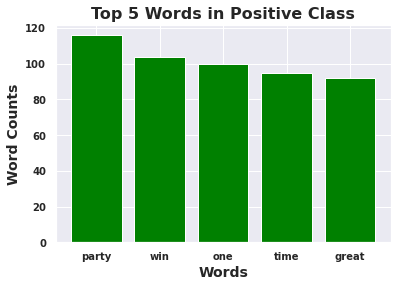

In [45]:
# Graphing the top 5 words and their counts for the Positive class
top_5_positive_words = top_20_positive_words[:5]
words_positive, counts_positive = zip(*top_5_positive_words)

# Create a bar chart for the positive class
plt.bar(words_positive, counts_positive, color='green')
plt.xlabel('Words', fontsize=14, fontweight='bold')  # Adjust fontsize and fontweight as needed
plt.ylabel('Word Counts', fontsize=14, fontweight='bold')  # Adjust fontsize and fontweight as needed
plt.title('Top 5 Words in Positive Class', fontsize=16, fontweight='bold')  # Adjust fontsize and fontweight as needed
plt.xticks(fontsize=10, fontweight='bold')  # Adjust fontsize and fontweight as needed
plt.yticks(fontsize=10, fontweight='bold')  # Adjust fontsize and fontweight as needed
plt.show()

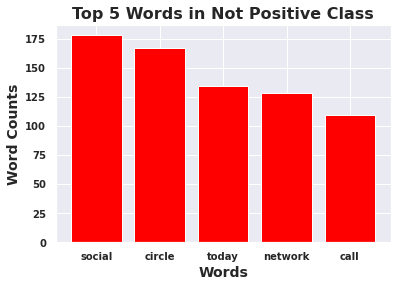

In [43]:
# Graphing the top 5 words and their counts for the Not Positive class
top_5_not_positive_words = top_20_not_positive_words[:5]
words_not_positive, counts_not_positive = zip(*top_5_not_positive_words)

# Create a bar chart for the top 5 Not Positive class words
plt.bar(words_not_positive, counts_not_positive, color='red')
plt.xlabel('Words', fontsize=14, fontweight='bold')  # Adjust fontsize and fontweight as needed
plt.ylabel('Word Counts', fontsize=14, fontweight='bold')  # Adjust fontsize and fontweight as needed
plt.title('Top 5 Words in Not Positive Class', fontsize=16, fontweight='bold')  # Adjust fontsize and fontweight as needed
plt.xticks(fontsize=10, fontweight='bold')  # Adjust fontsize and fontweight as needed
plt.yticks(fontsize=10, fontweight='bold')  # Adjust fontsize and fontweight as needed
plt.show()

# Modeling

In [31]:
# Fitting the Multinomial Naive Bayes Classifier on our training data
mnb = MultinomialNB(alpha=0.5)

mnb.fit(X_train2_vec, y_train2)

MultinomialNB(alpha=0.5)

In [32]:
# Evaluating our training data
y_train_pred = mnb.predict(X_train2_vec)
accuracy_score(y_train2, y_train_pred)

0.86670165310942

In [33]:
# Generating model predictions and getting an accuracy score for our Testing Data
y_pred = mnb.predict(X_val_vec)
accuracy_score(y_val, y_pred)

0.6474291710388248

In [34]:
# calculating a precision score
precision_score(y_val, y_pred)

0.6425925925925926

We got an 85% accuracy score on our training data and roughly a 65% accuracy score on our testing data. We had a similar score of 64% on precision. Our model did do significantly better on the training data most likely due to overfitting from noise in the training data (too many words with lt).

In [35]:
# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0],              # alpha parameter for MultinomialNB
}

# Initialize MultinomialNB classifier
mnb = MultinomialNB()

# Perform GridSearchCV with accuracy as the scoring metric with 5 folds
grid_search = GridSearchCV(mnb, param_grid, cv=5, scoring='accuracy')

# Training the GridSearchCV on the training data
grid_search.fit(X_train2_vec, y_train2)

# Geting the best accuracy score and hyperparameters
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)

Best Accuracy: 0.649962332690065
Best Parameters: {'alpha': 0.5}


The GridSearch helped reveal what the best alpha should be to improve accuracy.

In [36]:
# Setting up a confusion matrix on our testing data
cm = confusion_matrix(y_val, y_pred)


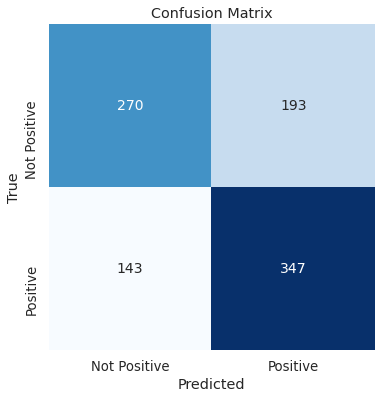

In [37]:
# Set up a figure and axis
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            annot_kws={"size": 14}, square=True,
            xticklabels=['Not Positive', 'Positive'],
            yticklabels=['Not Positive', 'Positive'])

# Labeling and viewing the cm
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Fitting a tfidf on training data to make predictions with words that appear in 5%-95% of tweets
tfidf = TfidfVectorizer(min_df=0.05, max_df=0.95)
X_train2_vec = tfidf.fit_transform(X_train2)
X_val_vec = tfidf.transform(X_val)
mnb2 = MultinomialNB()
mnb2.fit(X_train2_vec, y_train2)
y_pred2 = mnb2.predict(X_val_vec)

accuracy_score(y_val, y_pred2)

0.4858342077649528

In [39]:
precision_score(y_val, y_pred2)

0.5

The tfidf mnb model with min, max hyperparameters led to a worse accuracy score of almost 50%, and had a worse precision score as well at 52%.

In [40]:
# Fitting a Random Forest Classifier on training data, and making predictions on validation data
rf = RandomForestClassifier(n_estimators=1000, max_features=5, max_depth=5)
rf.fit(X_train2_vec, y_train2)
y_pred3 = rf.predict(X_val_vec)
precision_score(y_val, y_pred3)

0.5214368482039398

In [41]:
accuracy_score(y_val, y_pred3)

0.5246589716684156

The random forest model with hyperparameters did not perform as well as the mnb model with alpha set to 0.5. This model had an accuracy score of 52%

# Evaluation

Our best performing model was our Multinomial Bayes model that used a GridSearch with hyperparameters, the alpha was set to 0.5. This is an example of Laplace smoothing which avoids the problem of zero probabilities of unseen words in the training data. The model was trained on data using a count vectorizer of all the words in the corpus after preprocessing. It had an accuracy score of about 65% which is not great in determining whether tweets had positive sentiment or not. It also had a precision score that was roughly the same. We looked at accuracy as the best metric because in terms of minimizing false/negatives and false/positives, one was not more important than the other. Therefore precision and recall didn't matter as much as accuracy. It was a better metric because we had a balance in our classes. Our confusion matrix confirmed this by showing we had 616 correct predictions out of 953 possible instances in our sample.

# Conclusion

Our Multinomial Bayes model that was trained on vectorized data with the help of a Grid Search for hyperparameter tuning was our best performing model. This model had an 85% accuracy score on training data and a 65% accuracy on testing data. This is most likely due to overfitting from noise in the data. When we looked at feature importances and didn't see any words with significant importance which was most likely the contributing factor. The sample from our confusion matrix showed that the model correctly classified instances 616 times out of 953 instances. We discovered the top 5 frequently used words in the Positive class were 'party', 'win', 'one', 'time' and 'great'. The top 5 words for the Not Positive class were 'social', 'circle', 'today', 'network', and 'call'. We need to gather a lot more data, specifically with negative sentiment as this was lacking in the dataset forcing us to create a Not Positive class which was not ideal because there was a lot of data with no emotion mixed in with only a little bit of negative sentiment.

## Limitations

Some limitations of the data was that there was initially a pretty heavy class imbalance in sentiment. Over half of the data (in this case tweets) showed to have no emotion. With only 33% showing positive sentiment and only around 6% showing negative sentiment. This forced me to combine no emotion tweets and negative tweets to create a 'Not Positive' category. This contributed to our models not being very accurrate. There were also a lot of missing values (nearly 2/3) of the data was missing from the 'emotion_in_tweet_is_directed_at' column so I was not able to analyze sentiment regarding certain products. There was a lot of noise in the data, there were not many words with high significant importance. After cleaning the data we were only able to work with around 6,000 entries which is fairly low when it comes to building predictive models. 

## Next Steps

We need to gather more data on negative sentiment as well as positive sentiment. Negative sentiment is just as useful and in some cases more useful information to have to know what to avoid and how to make improvements. We need to gather 10x more data from other social media platforms as well, not just twitter. Gathering information on specific areas of the conference (whether it be in film, music, education or brands in tech) will help SXSW become an even better more well rounded event rather than just looking at general sentiment towards the event. 